In [ ]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.datasets as dset
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch



In [ ]:

opt = {}
opt["n_epochs"] = 200
opt["batch_size"] = 64
opt["lr"] = 0.01
opt["b1"] = 0.5
opt["b2"] = 0.999
opt["n_cpu"] = 8
opt["latent_dim"] = 100
opt["img_size"] = 64
opt["channels"] = 3
opt["sample_interval"] = 400
print(opt)



{'n_epochs': 200, 'batch_size': 64, 'lr': 0.01, 'b1': 0.5, 'b2': 0.999, 'n_cpu': 8, 'latent_dim': 100, 'img_size': 64, 'channels': 3, 'sample_interval': 400}


In [ ]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset.git


Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8659/8659), done.
remote: Total 385858 (delta 37), reused 8688 (delta 34), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 28.12 MiB/s, done.
Resolving deltas: 100% (1197/1197), done.
Updating files: 100% (90503/90503), done.


In [ ]:
!ls
%cd Fruit-Images-Dataset


Fruit-Images-Dataset  images  sample_data
/content/Fruit-Images-Dataset


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


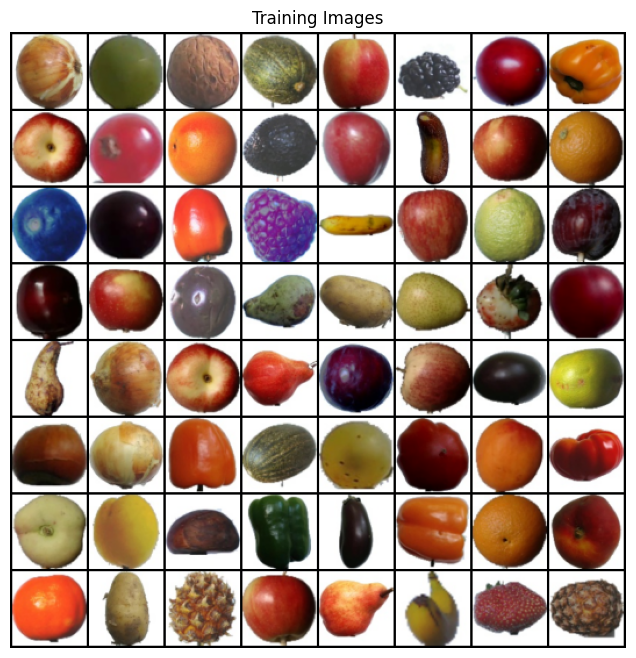

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Root directory for dataset
# dataroot = r"/content/gdrive/MyDrive/data/test"
dataroot = "Training"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(opt["img_size"]),
                               transforms.CenterCrop(opt["img_size"]),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt["batch_size"] ,
                                         shuffle=True, num_workers=2)
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
cuda = True if torch.cuda.is_available() else False
import torch.optim as optim

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)



class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( opt["latent_dim"], 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( 64, opt["channels"], 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(opt["channels"], 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# Create the generator
generator = Generator().to(device)


# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
generator.apply(weights_init)
discriminator = Discriminator().to(device)


# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
discriminator.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:


# Loss function
adversarial_loss = torch.nn.BCELoss()
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# # Create batch of latent vectors that we will use to visualize
# #  the progression of the generator
# fixed_noise = torch.randn(64,opt["latent_dim"] , 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=opt["lr"] , betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=opt["lr"], betas=(0.5, 0.999))


# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(opt["n_epochs"]):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, opt["latent_dim"], 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, opt["n_epochs"], i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == opt["n_epochs"]-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    torch.save(generator.state_dict(), r"/content/gdrive/MyDrive/fruit.pth")

Starting Training Loop...
[0/200][0/1058]	Loss_D: 1.7859	Loss_G: 3.8833	D(x): 0.4323	D(G(z)): 0.4623 / 0.0280
[0/200][50/1058]	Loss_D: 0.6822	Loss_G: 14.0863	D(x): 0.9861	D(G(z)): 0.3080 / 0.0000
[0/200][100/1058]	Loss_D: 0.0849	Loss_G: 3.0785	D(x): 0.9547	D(G(z)): 0.0231 / 0.0901
[0/200][150/1058]	Loss_D: 1.5793	Loss_G: 17.2063	D(x): 0.9936	D(G(z)): 0.6438 / 0.0000
[0/200][200/1058]	Loss_D: 0.1415	Loss_G: 5.4216	D(x): 0.9234	D(G(z)): 0.0431 / 0.0115
[0/200][250/1058]	Loss_D: 0.2245	Loss_G: 4.2011	D(x): 0.8626	D(G(z)): 0.0486 / 0.0215
[0/200][300/1058]	Loss_D: 0.1471	Loss_G: 3.4642	D(x): 0.9384	D(G(z)): 0.0717 / 0.0468
[0/200][350/1058]	Loss_D: 0.2461	Loss_G: 2.0998	D(x): 0.8619	D(G(z)): 0.0584 / 0.1747
[0/200][400/1058]	Loss_D: 1.2576	Loss_G: 0.0297	D(x): 0.3910	D(G(z)): 0.0260 / 0.9717
[0/200][450/1058]	Loss_D: 0.5302	Loss_G: 1.2158	D(x): 0.6740	D(G(z)): 0.0438 / 0.3652
[0/200][500/1058]	Loss_D: 0.4227	Loss_G: 3.6812	D(x): 0.9534	D(G(z)): 0.2815 / 0.0339
[0/200][550/1058]	Loss_D: 0.4

KeyboardInterrupt: ignored

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


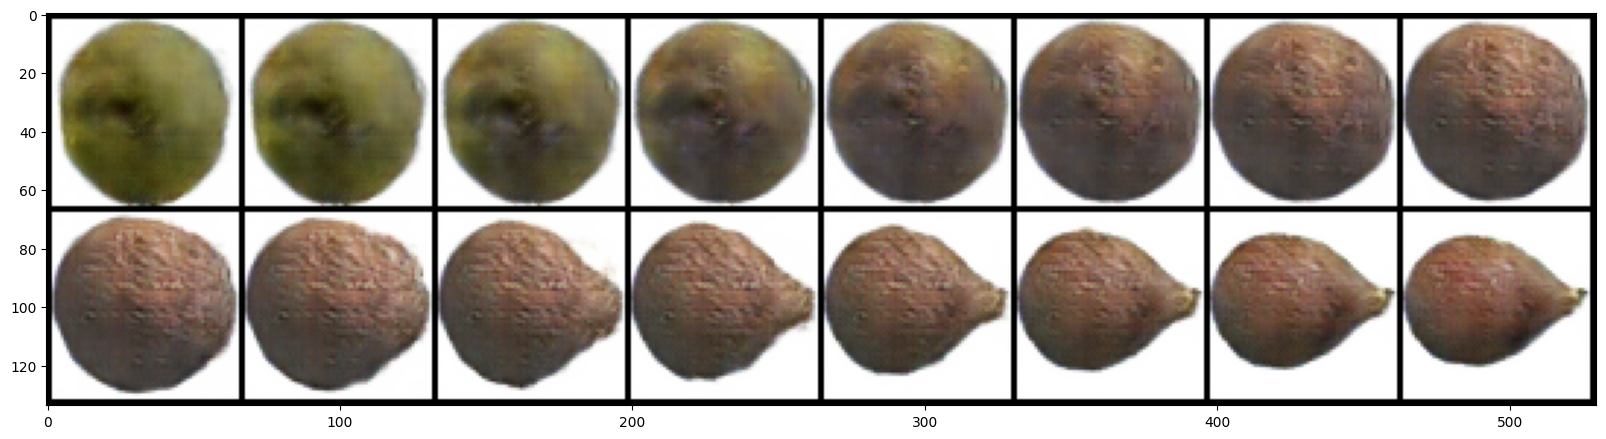

In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
import torch
drive.mount('/content/gdrive')

model = Generator()
model.load_state_dict(torch.load(r"/content/gdrive/MyDrive/fruit_epoch50_tanh.pth"))
model.eval()
generator = model

segments = 16
noise1 = torch.randn(opt["latent_dim"], 1, 1)
noise2 = torch.randn(opt["latent_dim"], 1, 1)
noise = torch.randn(segments, opt["latent_dim"], 1, 1)
for i in range(0,segments):
  noise[i] = torch.lerp(noise1,noise2,1/(segments-1)*i)
# noise = torch.randn(64, opt["latent_dim"], 1, 1)

# Generate a batch of images
gen_imgs = generator(noise)
figure = plt.figure(figsize=(20, 20))
img = vutils.make_grid(gen_imgs, padding=2, normalize=True)
plt.imshow(img.cpu().permute(1, 2, 0).detach().numpy())

